# Packages

In [37]:
from astropy.io import fits
from astropy import stats
from scipy import constants
from scipy import interpolate
from scipy import optimize
from scipy import integrate
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import time
from tqdm import tqdm

# I) Data input

In [2]:
#Read data
fitsFile_ch1 = "./MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch1-shortmediumlong/jw02260-o005_t005_miri_ch1-shortmediumlong_x1d.fits"
hdul_ch1 = fits.open(fitsFile_ch1)
fitsFile_ch2 = "./MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch2-shortmediumlong/jw02260-o005_t005_miri_ch2-shortmediumlong_x1d.fits"
hdul_ch2 = fits.open(fitsFile_ch2)
fitsFile_ch3 = "./MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch3-shortmediumlong/jw02260-o005_t005_miri_ch3-shortmediumlong_x1d.fits"
hdul_ch3 = fits.open(fitsFile_ch3)
fitsFile_ch4 = "./MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch4-shortmediumlong/jw02260-o005_t005_miri_ch4-shortmediumlong_x1d.fits"
hdul_ch4 = fits.open(fitsFile_ch4)
print(hdul_ch1.info())
print('###############################################################################')
print(hdul_ch1[1].header)
# output = open('./output.txt', 'a')
# output.write(str(hdul_ch1[0].header))
# output.close()
#what is the primary and asdf and different headers?

Filename: ./MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch1-shortmediumlong/jw02260-o005_t005_miri_ch1-shortmediumlong_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     373   ()      
  1  EXTRACT1D     1 BinTableHDU     69   3438R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [67910B]   
None
###############################################################################
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  140 / length of dimension 1                          NAXIS2  =                 3438 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =  

In [3]:
#Data arrays
wvlName = 'WAVELENGTH'
fluxName = 'BACKGROUND'
errorName = 'BKGD_ERROR'
wvl_ch1 = hdul_ch1[1].data[wvlName]
flux_ch1 = hdul_ch1[1].data[fluxName]
bkgdErr_ch1 = hdul_ch1[1].data[errorName]
wvl_ch2 = hdul_ch2[1].data[wvlName]
flux_ch2 = hdul_ch2[1].data[fluxName]
bkgdErr_ch2 = hdul_ch2[1].data[errorName]
wvl_ch3 = hdul_ch3[1].data[wvlName]
flux_ch3 = hdul_ch3[1].data[fluxName]
bkgdErr_ch3 = hdul_ch3[1].data[errorName]
wvl_ch4 = hdul_ch4[1].data[wvlName]
flux_ch4 = hdul_ch4[1].data[fluxName]
bkgdErr_ch4 = hdul_ch4[1].data[errorName]

In [6]:
#Basic info:
print(wvl_ch1[0],wvl_ch1[-1])
print(wvl_ch2[0],wvl_ch2[-1])
print(wvl_ch3[0],wvl_ch3[-1])
print(wvl_ch4[0],wvl_ch4[-1])
print(wvl_ch1.shape)
print(wvl_ch2.shape)
print(wvl_ch3.shape)
print(wvl_ch4.shape)

4.900400095357327 7.650000025896588
7.5106502288836055 11.700550240289886
11.551250190706924 17.978750047041103
17.70300076296553 28.70100085856393
(3438,)
(3224,)
(2572,)
(1834,)


#### Connection points: (7.5,11.5,17.7)

# II) Data  JWST

In [8]:
#Function
def locate(arr,x): #return arr[i] just larger than x
    i = 0
    while arr[i] < x:
        i += 1
    return i

def dopplerSh(wvl,flux,v,err=None):
    dopplerFactor = np.sqrt((1+v/constants.c)/(1-v/constants.c))
    print('Doppler factor = ', dopplerFactor)
    new_wvl = dopplerFactor*wvl
    new_flux = np.interp(wvl, new_wvl, flux)
    new_err = np.interp(wvl, new_wvl, err)
    return wvl, new_flux, new_err

Text(0, 0.5, '$\\Phi$ (MJy/sr)')

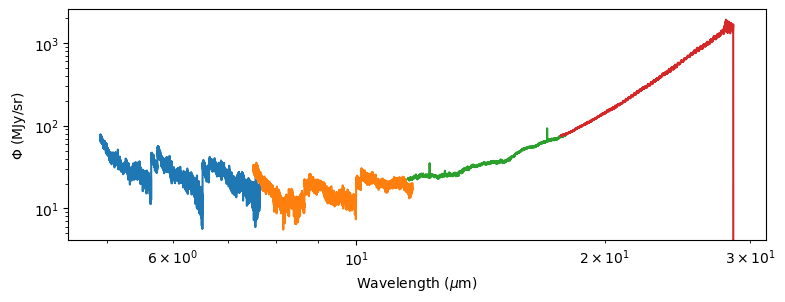

In [9]:
#Preview
plt.figure(figsize=(9,3))
plt.step(wvl_ch1,flux_ch1)
plt.step(wvl_ch2,flux_ch2)
plt.step(wvl_ch3,flux_ch3)
plt.step(wvl_ch4,flux_ch4)
plt.yscale('log')
plt.xscale('log')
# plt.ylim(0.01,0.5)
# plt.xlim(2.0,2.5)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (MJy/sr)")

In [10]:
wvlM1 = 7.6
wvlM2 = 11.6
wvlM3 = 17.8
wvlM4 = 28.6
p2_ch1 = locate(wvl_ch1,wvlM1)+1
p1_ch2 = locate(wvl_ch2,wvlM1)
p2_ch2 = locate(wvl_ch2,wvlM2)+1
p1_ch3 = locate(wvl_ch3,wvlM2) 
p2_ch3 = locate(wvl_ch3,wvlM3)+1
p1_ch4 = locate(wvl_ch4,wvlM3) 
p2_ch4 = locate(wvl_ch4,wvlM4)

In [11]:
#Truncated spectrums
wvl_ch1_t = wvl_ch1[:p2_ch1]
wvl_ch2_t = wvl_ch2[p1_ch2:p2_ch2]
wvl_ch3_t = wvl_ch3[p1_ch3:p2_ch3]
wvl_ch4_t = wvl_ch4[p1_ch4:p2_ch4]

flux_ch1_t = flux_ch1[:p2_ch1]
flux_ch2_t = flux_ch2[p1_ch2:p2_ch2]
flux_ch3_t = flux_ch3[p1_ch3:p2_ch3]
flux_ch4_t = flux_ch4[p1_ch4:p2_ch4]

bkgdErr_ch1_t = bkgdErr_ch1[:p2_ch1]
bkgdErr_ch2_t = bkgdErr_ch2[p1_ch2:p2_ch2]
bkgdErr_ch3_t = bkgdErr_ch3[p1_ch3:p2_ch3]
bkgdErr_ch4_t = bkgdErr_ch4[p1_ch4:p2_ch4]

print(wvl_ch1_t[-1],wvl_ch2_t[0])
print(wvl_ch2_t[-1],wvl_ch3_t[0])
print(wvl_ch3_t[-1],wvl_ch4_t[0])

7.60040002714959 7.600350229127798
11.60045024001738 11.601250189589337
17.801250051008537 17.80500076385215


In [14]:
#Locate the segment
p1 = locate(wvl_ch1,5.350) 
p2 = locate(wvl_ch1,5.525)
wvlCut = wvl_ch1[p1:p2]
fluxCut = flux_ch1[p1:p2]
errorCut = bkgdErr_ch1[p1:p2]
plt.figure(figsize=(9,3))
plt.step(wvlCut,fluxCut,'black')
plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
#plt.ylim(0.005,0.02)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (MJy/sr)")
plt.close()

In [17]:
#Spectrum plot
plt.figure(figsize=(9,6))

plt.subplot(211)  
plt.step(wvl_ch1_t,flux_ch1_t)
plt.step(wvl_ch2_t,flux_ch2_t)
plt.step(wvl_ch3_t,flux_ch3_t)
plt.step(wvl_ch4_t,flux_ch4_t)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (Jy/sr)")
plt.xscale('log')
plt.yscale('log')
#plt.ylim(0, 0.3)

plt.subplot(212)
plt.step(wvlCut,fluxCut,'black')
plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
#plt.ylim(0.08,0.14)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (Jy/sr)")
plt.tight_layout(pad=0.9)
plt.close()

# III) Barycenter to galactic center

In [18]:
#Corrected spectrum
solarV = 250000 #m/s
longitude = 300.3416019*math.pi/180  #blueshift
latitude = -16.7606576*math.pi/180
solarLosV = solarV*np.sin(longitude)*np.cos(latitude)
wvl_ch1_c, flux_ch1_c, bkgdErr_ch1_c = dopplerSh(wvl_ch1,flux_ch1,solarLosV, err=bkgdErr_ch1)
wvl_ch2_c, flux_ch2_c, bkgdErr_ch2_c = dopplerSh(wvl_ch2,flux_ch2,solarLosV, err=bkgdErr_ch2)
wvl_ch3_c, flux_ch3_c, bkgdErr_ch3_c = dopplerSh(wvl_ch3,flux_ch3,solarLosV, err=bkgdErr_ch3)
wvl_ch4_c, flux_ch4_c, bkgdErr_ch4_c = dopplerSh(wvl_ch4,flux_ch4,solarLosV, err=bkgdErr_ch4)

Doppler factor =  0.9993111225703655
Doppler factor =  0.9993111225703655
Doppler factor =  0.9993111225703655
Doppler factor =  0.9993111225703655


In [19]:
#Truncated corrected spectrum
wvl_ch1_ct = wvl_ch1_c[:p2_ch1]
wvl_ch2_ct = wvl_ch2_c[p1_ch2:p2_ch2]
wvl_ch3_ct = wvl_ch3_c[p1_ch3:p2_ch3]
wvl_ch4_ct = wvl_ch4_c[p1_ch4:p2_ch4]

flux_ch1_ct = flux_ch1_c[:p2_ch1]
flux_ch2_ct = flux_ch2_c[p1_ch2:p2_ch2]
flux_ch3_ct = flux_ch3_c[p1_ch3:p2_ch3]
flux_ch4_ct = flux_ch4_c[p1_ch4:p2_ch4]

bkgdErr_ch1_ct = bkgdErr_ch1_c[:p2_ch1]
bkgdErr_ch2_ct = bkgdErr_ch2_c[p1_ch2:p2_ch2]
bkgdErr_ch3_ct = bkgdErr_ch3_c[p1_ch3:p2_ch3]
bkgdErr_ch4_ct = bkgdErr_ch4_c[p1_ch4:p2_ch4]

In [20]:
#Locate the segment
wvlCut_c = wvl_ch1_c[p1:p2]
fluxCut_c = flux_ch1_c[p1:p2]
errorCut_c = bkgdErr_ch1_c[p1:p2]

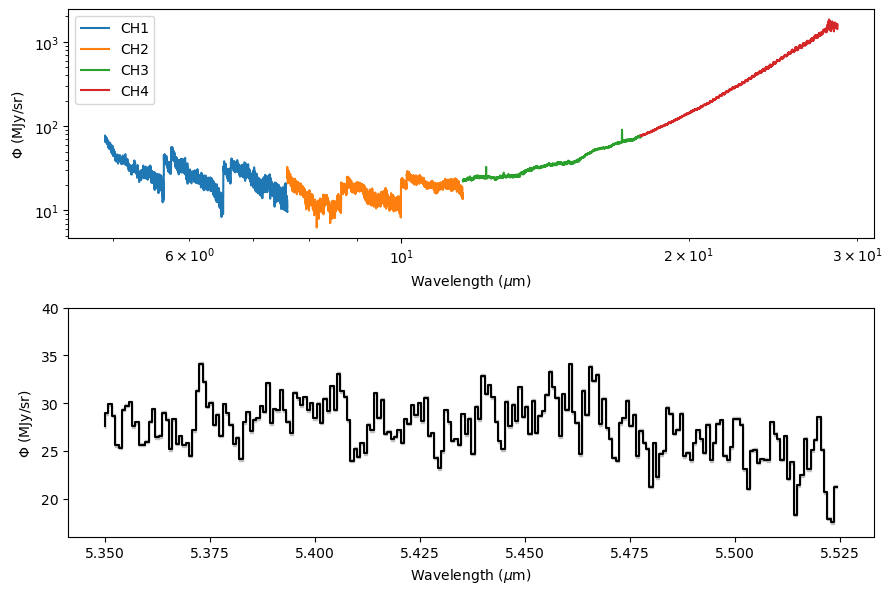

In [26]:
#plot
plt.figure(figsize=(9,6))
plt.subplot(211)  
plt.step(wvl_ch1_ct,flux_ch1_ct)
plt.step(wvl_ch2_ct,flux_ch2_ct)
plt.step(wvl_ch3_ct,flux_ch3_ct)
plt.step(wvl_ch4_ct,flux_ch4_ct)
plt.xscale('log')
plt.yscale('log')
plt.legend(('CH1','CH2','CH3','CH4'))
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (MJy/sr)")

plt.subplot(212)
plt.step(wvlCut_c,fluxCut_c,'black')
plt.fill_between(wvlCut_c,fluxCut_c+errorCut_c,fluxCut_c-errorCut_c,step="pre",color='silver')
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (MJy/sr)")
plt.ylim(16,40)
plt.tight_layout(pad=0.9)
#plt.savefig("TCha_spectrum.pdf")
plt.show()

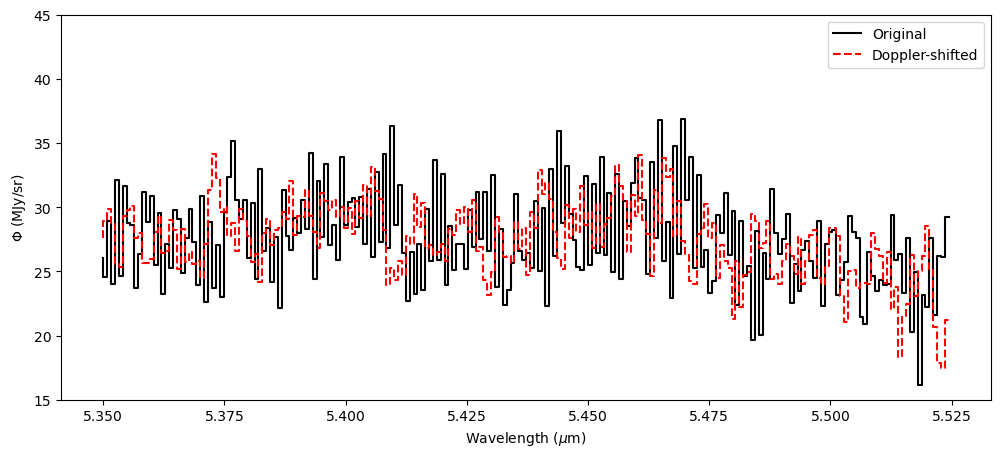

In [32]:
#Comparison
plt.figure(figsize=(12,5))
plt.step(wvlCut,fluxCut,'black')
plt.step(wvlCut_c,fluxCut_c,'red',ls='--')
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (MJy/sr)")   
plt.legend(['Original','Doppler-shifted'])
plt.ylim(15,45)
#plt.savefig("Tcha_dopplerShift.pdf")
plt.show()

The spectrum fluctuates quite significantly => the interpretation may not be very accurate.

# IV) Data analysis 

In [33]:
#Parameters
J_to_GeV = 6.242  #1e9
kpc_to_cm = 3.086e12  #1e9
rho_s = 0.18  #GeV/cm^3
rs = 24  #kpc
R_sun = 8.27  #kpc

#Conversion: mass (eV) <=> wavelength (um)
def massToWvl(m):
    return 2*constants.Planck*constants.c/m/constants.e/1e-6

def wvlToMass(wvl):
    return 2*constants.Planck*constants.c/wvl/constants.e/1e-6

def couplingToGamma(g,ma):  #GeV-1 => s-1
    return g**2*ma**3/64/np.pi/658.2119569

def gammaToCoupling(gamma,ma):  #s-1 => GeV-1
    return np.sqrt(64*math.pi*658.2119569*gamma/ma**3)

#FWHM estimation:
def FWHMestim(S_spec,M_spec,L_spec):
    Swvl = np.mean(S_spec[:2])
    Mwvl = np.mean(M_spec[:2])
    Lwvl = np.mean(L_spec[:2])
    Sres = np.mean(S_spec[2:])
    Mres = np.mean(M_spec[2:])
    Lres = np.mean(L_spec[2:])
    return (Swvl/Sres+Mwvl/Mres+Lwvl/Lres)/3

#NFW profile in terms of observing distance:
def NFW_profile(s):
    r_rs = np.sqrt(R_sun*R_sun+s*s+s*np.cos(longitude)*np.cos(latitude))/rs
    return rho_s/(r_rs+r_rs*r_rs)

In [34]:
massArr_ch1 = wvlToMass(wvl_ch1_ct)  
massArr_ch2 = wvlToMass(wvl_ch2_ct) 
massArr_ch3 = wvlToMass(wvl_ch3_ct)  
massArr_ch4 = wvlToMass(wvl_ch4_ct) 

In [35]:
S_spec_ch1 = np.array([4.9,5.74,3320,3710])
M_spec_ch1 = np.array([5.66,6.63,3190,3750])
L_spec_ch1 = np.array([6.53,7.65,3100,3610])
S_spec_ch2 = np.array([7.51,8.77,2990,3110])
M_spec_ch2 = np.array([8.67,10.13,2750,3170])
L_spec_ch2 = np.array([10.02,11.70,2860,3300])
S_spec_ch3 = np.array([11.55,13.47,2530,2880])
M_spec_ch3 = np.array([13.34,15.57,1790,2640])
L_spec_ch3 = np.array([15.41,17.98,1980,2790])
S_spec_ch4 = np.array([17.70,20.95,1460,1930])
M_spec_ch4 = np.array([20.69,24.48,1680,1770])
L_spec_ch4 = np.array([24.19,27.90,1630,1330])

In [39]:
#Parameters
D = integrate.quad(NFW_profile,0,np.inf)[0]*(kpc_to_cm/J_to_GeV)*1e18  #TJy/sr  
sigma_v = 160000/constants.c #m/s/c
d_lmd_ch1 = FWHMestim(S_spec_ch1,M_spec_ch1,L_spec_ch1)  #um
d_lmd_ch2 = FWHMestim(S_spec_ch2,M_spec_ch2,L_spec_ch2)  #um
d_lmd_ch3 = FWHMestim(S_spec_ch3,M_spec_ch3,L_spec_ch3)  #um
d_lmd_ch4 = FWHMestim(S_spec_ch4,M_spec_ch4,L_spec_ch4)  #um
print('d_lmd =', d_lmd_ch1,d_lmd_ch2,d_lmd_ch3,d_lmd_ch4)
print('D =', D/(kpc_to_cm/J_to_GeV)/1e18)

d_lmd = 0.0017992235568887905 0.003123500720222032 0.006050242771447129 0.014030635512388109
D = 7.857161763677847


#### Remark: 1) The response function and the FWHM resolution are approximate and not optimized. 2) The data has a long exposure exposure time but a short integration (about 70s). (what's the effect?)

### Functions

In [80]:
def minimization(x,y,BOUND=(-1e9,1e9)):
    f = interpolate.interp1d(x,y)
    F = lambda x : float(f(x))
    min = optimize.minimize_scalar(F,bounds=BOUND)
    return min.x, min.fun

def theoFlux(wvl,lmd0, delta_lmd, gamma):  #produce an array of theoretical flux  
    w = lmd0*sigma_v  #um
    sigma_lmd = delta_lmd/2/np.sqrt(2*np.log(2))  #um
    newSigma2 = sigma_lmd*sigma_lmd+w*w  #um^2 
    normalize = lmd0*lmd0/np.sqrt(2*math.pi*newSigma2)/constants.c
    spectrum_eff = normalize*np.exp(-(wvl-lmd0)**2/2/newSigma2) #us
    fluxArr = gamma*D*spectrum_eff/4/math.pi      
    # print('###########################')
    # print('w = ', w)
    # print('sigma_lmd', sigma_lmd)
    # print('sigma = ', np.sqrt(newSigma2))
    # print('normalize = ', normalize)
    # print('D = ', D)
    # print('###########################')
    return fluxArr
    
def chi2MinusFour_conservative(obsWvl,obsFlux,obsError,gammaArr,delta_lmd):  #output (chi2 - 4) in the searching space of gamma and lamda0
    start = time.time()
    chi2M4 = np.zeros((len(gammaArr),len(obsWvl)))
    testRange = 150  # ~75FWHM of the DM line
    
    for i in range(len(obsWvl)):
        lmd0 = obsWvl[i]
        #Analyse a subregion with width=150*FHWM:
        if (i>=testRange) & (i<=len(obsWvl)-testRange):
            wvl = obsWvl[i-testRange:i+testRange]
            flux = obsFlux[i-testRange:i+testRange]
            error = obsError[i-testRange:i+testRange]
        elif (i<testRange):
            wvl = obsWvl[:testRange*2]
            flux = obsFlux[:testRange*2]
            error = obsError[:testRange*2]
        elif (i>len(obsWvl)-testRange):
            wvl = obsWvl[-testRange*2:]
            flux = obsFlux[-testRange*2:]
            error = obsError[-testRange*2:]

        for j in range(len(gammaArr)):
            gamma = gammaArr[j]
            flux_model = theoFlux(wvl,lmd0,delta_lmd,gamma)
            chi2M4[j,i] = np.sum(((flux_model-flux)/error)**2,where=(flux_model-flux)>0) - 4 #[flux] = MJy/sr
            
    end = time.time()
    print('Duration: ', (end - start)/60, ' [min]')
    return chi2M4

def extractBound(wvl,gammaTest,chi2Minus4,c):  #chi2Minus4: row=gamma, column=wvl
    gammaBound = np.zeros(len(wvl))
    for i in range(len(wvl)):
        gammaBound[i] = np.interp(c,chi2Minus4[:,i],gammaTest)
    return gammaBound

class continuumFitting:  #gammaArr has to be monotonically increasing
    
    def __init__(self,obsWvl,obsFlux,obsError,delta_lmd):
        self.step = 3  #scanning the entire mass range in the given step (~FWHM of DM line)
        self.maskRange = 1  
        self.wvl = obsWvl
        self.flux = obsFlux
        self.error = obsError
        self.delta_lmd = delta_lmd  #FWHM instrumental resolution
        self.lenWvl = len(obsWvl)  #length of the input wavelength array
        self.wvl_bd = obsWvl[::self.step]  #wavelength array that corresponds to the testing masses
        self.test_len = len(self.wvl_bd)  #length of the testing wavelength array
        print('No. of test masses: ', self.test_len)
    
    def continuum(self,beta,wvl):
        wvlSpline = np.linspace(wvl[0],wvl[-1],len(beta))
        return interpolate.CubicSpline(wvlSpline,beta)(wvl)

    def lnlike_continuum(self,lmd0,gamma,beta,wvl,flux,error,mask=None):
        flux_model = theoFlux(wvl,lmd0,self.delta_lmd,gamma) + self.continuum(beta,wvl)
        return np.sum(((flux_model-flux)/error)**2,where=(mask==False)) 
        
    def clipSD_error(self, flux, contin_model, wvl, lmd0):
        clip_sd = np.std(abs(flux-contin_model))
        Dclip_sd = clip_sd
        i_unmask = self.maskRange + 1
        iter_threshold = clip_sd*0.01
        mask_condition = np.zeros(len(flux),dtype=bool)
        while (Dclip_sd>iter_threshold):
            upperLim = np.mean(abs(flux-contin_model),where=(mask_condition==False)) + 3*clip_sd
            for i in range(self.maskRange,len(flux)-self.maskRange):
                if (abs(wvl[i]==lmd0)):
                    i_unmask = i
                if (np.all(abs(flux-contin_model)[i-self.maskRange:i+self.maskRange+1] >= upperLim)):
                    mask_condition[i-self.maskRange:i+self.maskRange] = True
            _,_,clip_sd_new = stats.sigma_clipped_stats(abs(flux-contin_model),mask=mask_condition)
            Dclip_sd = clip_sd - clip_sd_new
            clip_sd = clip_sd_new
        if (wvl[self.maskRange]>=lmd0):
            i_unmask = self.maskRange + 1  
        elif (wvl[len(flux)-self.maskRange-1]<=lmd0):
            i_unmask = len(flux)-self.maskRange-2
        mask_condition[i_unmask-self.maskRange-1:i_unmask+self.maskRange+2] = False  #unmask a range of 5 bins
        return clip_sd, mask_condition

    def model_range(self,wvl,flux,error,i,testRange):
        if (self.step*i>=testRange) & (self.step*i<=self.lenWvl-testRange):
                wvlCut = self.wvl[self.step*i-testRange:self.step*i+testRange]
                fluxCut = self.flux[self.step*i-testRange:self.step*i+testRange]
                errorCut = self.error[self.step*i-testRange:self.step*i+testRange]
        elif (self.step*i<testRange):
            wvlCut = self.wvl[:testRange*2]
            fluxCut = self.flux[:testRange*2]
            errorCut = self.error[:testRange*2]
        elif (self.step*i>self.lenWvl-testRange):
            wvlCut = self.wvl[-testRange*2:]
            fluxCut = self.flux[-testRange*2:]
            errorCut = self.error[-testRange*2:]
        return wvlCut,fluxCut,errorCut
        
    def minChi2_continuum(self, lmd0, gammaArr, wvl, flux, error):
        chi2 = np.zeros(len(gammaArr))
        minBeta = np.zeros((len(gammaArr),5))
        initial = np.linspace(flux[0],flux[-1],5)

        ##################################

        likelihood = lambda beta : self.lnlike_continuum(lmd0, gammaArr[0], beta, wvl, flux, error)
        minLike = optimize.minimize(likelihood,initial)
        clip_sd, maskCondition = self.clipSD_error(flux,self.continuum(minLike.x,wvl),wvl,lmd0)
        errorFactor = np.mean(clip_sd/error)
        error_new = error*errorFactor
    
        for i in range(len(gammaArr)):
            gamma = gammaArr[i]
            likelihood = lambda beta : self.lnlike_continuum(lmd0, gamma, beta, wvl, flux, error_new, mask=maskCondition)
            minLike = optimize.minimize(likelihood,initial)
            minBeta[i,:] = minLike.x
            chi2[i] = minLike.fun
        return chi2, minBeta, error_new, errorFactor, maskCondition
        
    def constraints_continuum(self,gammaArr):
        start = time.time()
        testRange = 150  # ~75FWHM of the DM line
        error_new = np.zeros((self.test_len,testRange*2))
        chi2 = np.zeros((self.test_len,len(gammaArr)))  #Minimized wrt beta
        minBeta = np.zeros((self.test_len,len(gammaArr),5))
        errorFactor = np.zeros(self.test_len)
        mask = np.zeros((self.test_len,testRange*2))

        for i in tqdm(range(self.test_len)):
            lmd0 = self.wvl_bd[i]
            #Model a subinterval with width=150*FHWM:
            wvlCut, fluxCut, errorCut = self.model_range(self.wvl,self.flux,self.error,i,testRange)
            chi2[i,:], minBeta[i,:,:], error_new[i,:], errorFactor[i], mask[i,:] = self.minChi2_continuum(lmd0,gammaArr, wvlCut, fluxCut, errorCut)
            
        end = time.time()
        print('Duration: ', (end - start)/60, ' [min]')
        self.chisq = chi2
        self.beta = minBeta
        self.errorNew = error_new
        return chi2, minBeta, error_new, errorFactor, mask

    # def bestFit(self,lmd0,gammaArr,chi2,wvl,flux,error):
    #     gamma_bf,like_bf = minimization(gammaArr,chi2,BOUND=(0,gammaArr[np.argmin(chi2)+5]))
    #     initial = np.linspace(flux[0],flux[-1],5)
    #     likelihood = lambda beta : self.lnlike_continuum(lmd0, gamma_bf, beta, wvl, flux, error)
    #     minLike = optimize.minimize(likelihood,initial)
    #     minBeta = optimize.minimize(likelihood,initial).x
    #     return np.append(gamma_bf,minBeta), minLike.fun

    def detection_signif(self,chi2,gammaArr):
        N2 = np.min(chi2,axis=1) - chi2[:,0]
        return N2
        
    def extractBound_continuum(self,chi2,gammaArr,c):
        gammaBound = np.zeros(self.test_len)
        for i in range(self.test_len):
            min_i = np.argmin(chi2[i,:])
            d_chi2 = chi2[i,:] - np.min(chi2[i,:])
            gammaBound[i] = np.interp(c,d_chi2[min_i:],gammaArr[min_i:])
        return gammaBound

    def fitting_result(self, gammaArr, plot_i=0, plotFit=False, yLIM=(0,12), gamma_LIM=(0,5e-24), chi2_LIM=(0,5)):

        #Detection significance:
        n2 = self.detection_signif(self.chisq,gammaArr)
        plt.figure(figsize=(12,4))
        plt.plot(self.wvl_bd,np.sqrt(-n2))
        plt.ylim(yLIM)
        plt.axhline(y = 5, color = 'grey', linestyle = '--') 
        plt.xlabel('Wavelength ($\\mu$m)')
        plt.ylabel('|N|')
        plt.show()
        print('Significant detection:')
        for i in range(len(n2)):
            if np.sqrt(-n2[i])>5:
                print('N =', "{:.2f}".format(np.sqrt(-n2[i])), 'at (\u03BB_0,i) =', ("{:.2f}".format(self.wvl_bd[i]),i))
        min_i = np.argmin(n2)
        print('Strongest detection:')
        print('N =', "{:.2f}".format(np.sqrt(-n2[min_i])), 'at (\u03BB_0,i) =', ("{:.2f}".format(self.wvl_bd[min_i]),min_i))
        
        #Fitting result at specific lambda:
        if (plotFit == True):
            plt.figure(figsize=(12, 9))
            
            #Spectrum:
            testRange = 150  # ~75FWHM of the DM line
            wvl_model, flux_model, error_model = self.model_range(self.wvl,self.wvl,self.error,plot_i,testRange)  
            gamma_min_i = np.argmin(self.chisq[plot_i,:])
            theta_min  = np.append(gammaArr[gamma_min_i],self.beta[plot_i,gamma_min_i,:])
            best_fit_model = best_fit_model = theoFlux(wvl_model,self.wvl_bd[plot_i],self.delta_lmd,theta_min[0]) + self.continuum(theta_min[1:],wvl_model)

            plt.subplot(211)
            plt.plot(wvl_model,best_fit_model, color='red')
            plt.plot(wvl_model,self.continuum(self.beta[plot_i,0,:],wvl_model), color='blue')
            plt.step(wvl_model,flux_model,'black')
            plt.fill_between(wvl_model,flux_model+self.errorNew[plot_i],flux_model-self.errorNew[plot_i],step="pre",color='silver')
            plt.legend(('Best fit', 'Null'))
            #plt.ylim(0.08,0.14)
            plt.xlabel('Wavelength ($\\mu$m)')
            plt.ylabel("$\\Phi$ (MJy/sr)")

            #Chi2 against gamma
            plt.subplot(212)
            plt.plot(gammaArr,self.chisq[plot_i,:]/2/testRange,'-o')
            plt.axhline(y = self.chisq[plot_i,0]/2/testRange, color = 'grey', linestyle = '--') 
            plt.ylim(chi2_LIM)
            plt.xlim(gamma_LIM)
            plt.xlabel('$\\Gamma$ (Hz)')
            plt.ylabel('$\\chi^2$/dof')
            plt.show() 
            print('Parameters:', theta_min)
            print('chi2 =', np.min(self.chisq[plot_i,:]), 'N =', np.sqrt(-n2[plot_i]))

### Theoretical DM flux

lambda_0 (um) =  5.460400081210537 , ma (eV) =  0.45412129730140116
g (GeV-1)  =  4e-09 , gamma (Hz) =  1.1322438703376422e-23


Text(0, 0.5, '$\\Phi$ (MJy/sr)')

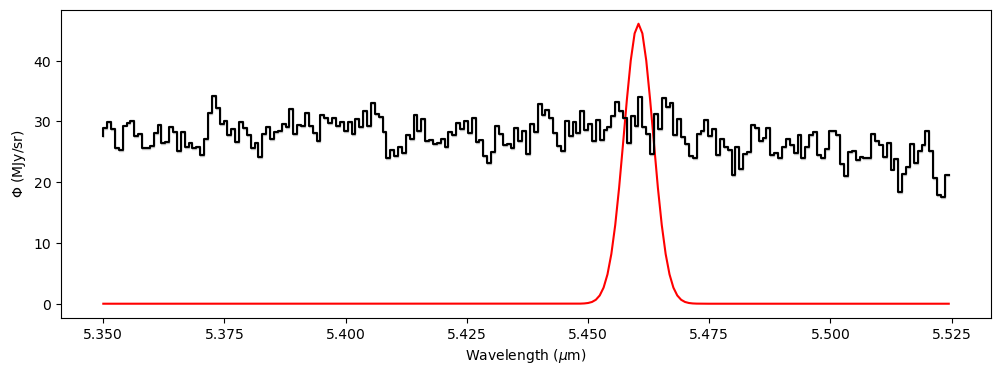

In [49]:
#Test Params
lmd0_test = wvlCut_c[locate(wvlCut_c,5.46)]
ma_test = wvlToMass(lmd0_test)
g_test = 4e-9  #GeV-1
gamma_test = couplingToGamma(g_test,ma_test)
print('lambda_0 (um) = ', lmd0_test, ', ma (eV) = ', ma_test)
print('g (GeV-1)  = ', g_test, ', gamma (Hz) = ', gamma_test)

#Results
theoFlux_test = theoFlux(wvlCut_c,lmd0_test,d_lmd_ch1,gamma_test)
plt.figure(figsize=(12,4))
plt.plot(wvlCut_c,theoFlux_test,color='red')
plt.step(wvlCut_c,fluxCut_c,'black')
plt.fill_between(wvlCut_c,fluxCut_c+errorCut_c,fluxCut_c-errorCut_c,step="pre",color='silver')
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('$\\Phi$ (MJy/sr)')
#plt.ylim(0,0.005)

### Conservative constraint

In [50]:
gammaTest1 = np.logspace(-24,np.log10(3e-23),600)
gammaTest2 = np.logspace(np.log10(8e-25),-23,600)
gammaTest3 = np.logspace(np.log10(2e-24),-23,800)
gammaTest4 = np.logspace(np.log10(5e-24),-22,1800)
chi2M4_1 = chi2MinusFour_conservative(wvl_ch1_ct,flux_ch1_ct,bkgdErr_ch1_ct,gammaTest1,d_lmd_ch1)
chi2M4_2 = chi2MinusFour_conservative(wvl_ch2_ct,flux_ch2_ct,bkgdErr_ch2_ct,gammaTest2,d_lmd_ch2)
chi2M4_3 = chi2MinusFour_conservative(wvl_ch3_ct,flux_ch3_ct,bkgdErr_ch3_ct,gammaTest3,d_lmd_ch3)
chi2M4_4 = chi2MinusFour_conservative(wvl_ch4_ct,flux_ch4_ct,bkgdErr_ch4_ct,gammaTest4,d_lmd_ch4)

Duration:  0.982342251141866  [min]
Duration:  0.861734131971995  [min]
Duration:  0.9800825476646423  [min]
Duration:  1.6177318811416626  [min]


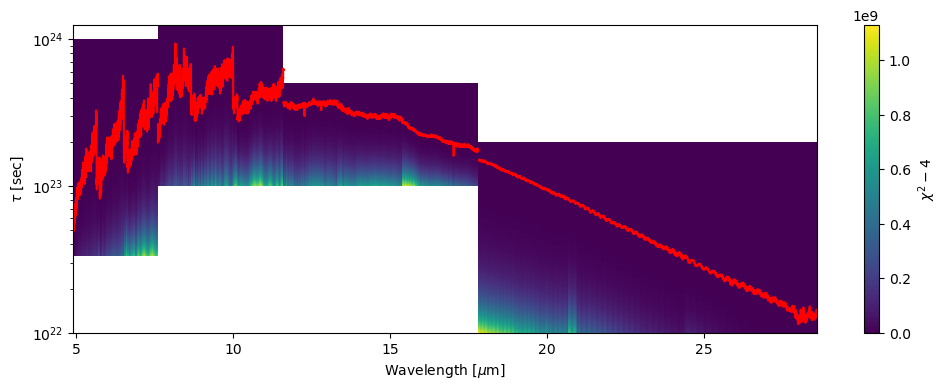

In [51]:
#Plot
wvl1, gammaTest_1 = np.meshgrid(wvl_ch1_ct,gammaTest1)
wvl2, gammaTest_2 = np.meshgrid(wvl_ch2_ct,gammaTest2)
wvl3, gammaTest_3 = np.meshgrid(wvl_ch3_ct,gammaTest3)
wvl4, gammaTest_4 = np.meshgrid(wvl_ch4_ct,gammaTest4)
plt.figure(figsize=(12,4))
plt.pcolormesh(wvl1, 1/gammaTest_1, chi2M4_1)
plt.pcolormesh(wvl2, 1/gammaTest_2, chi2M4_2)
plt.pcolormesh(wvl3, 1/gammaTest_3, chi2M4_3)
plt.pcolormesh(wvl4, 1/gammaTest_4, chi2M4_4)
plt.colorbar(label='$\\chi^2-4$')
plt.contour(wvl1, 1/gammaTest_1, chi2M4_1, 0, colors='red')
plt.contour(wvl2, 1/gammaTest_2, chi2M4_2, 0, colors='red')
plt.contour(wvl3, 1/gammaTest_3, chi2M4_3, 0, colors='red')
plt.contour(wvl4, 1/gammaTest_4, chi2M4_4, 0, colors='red')
plt.xlabel('Wavelength [$\\mu$m]')
plt.ylabel('$\\tau$ [sec]')
plt.yscale('log')
plt.show()

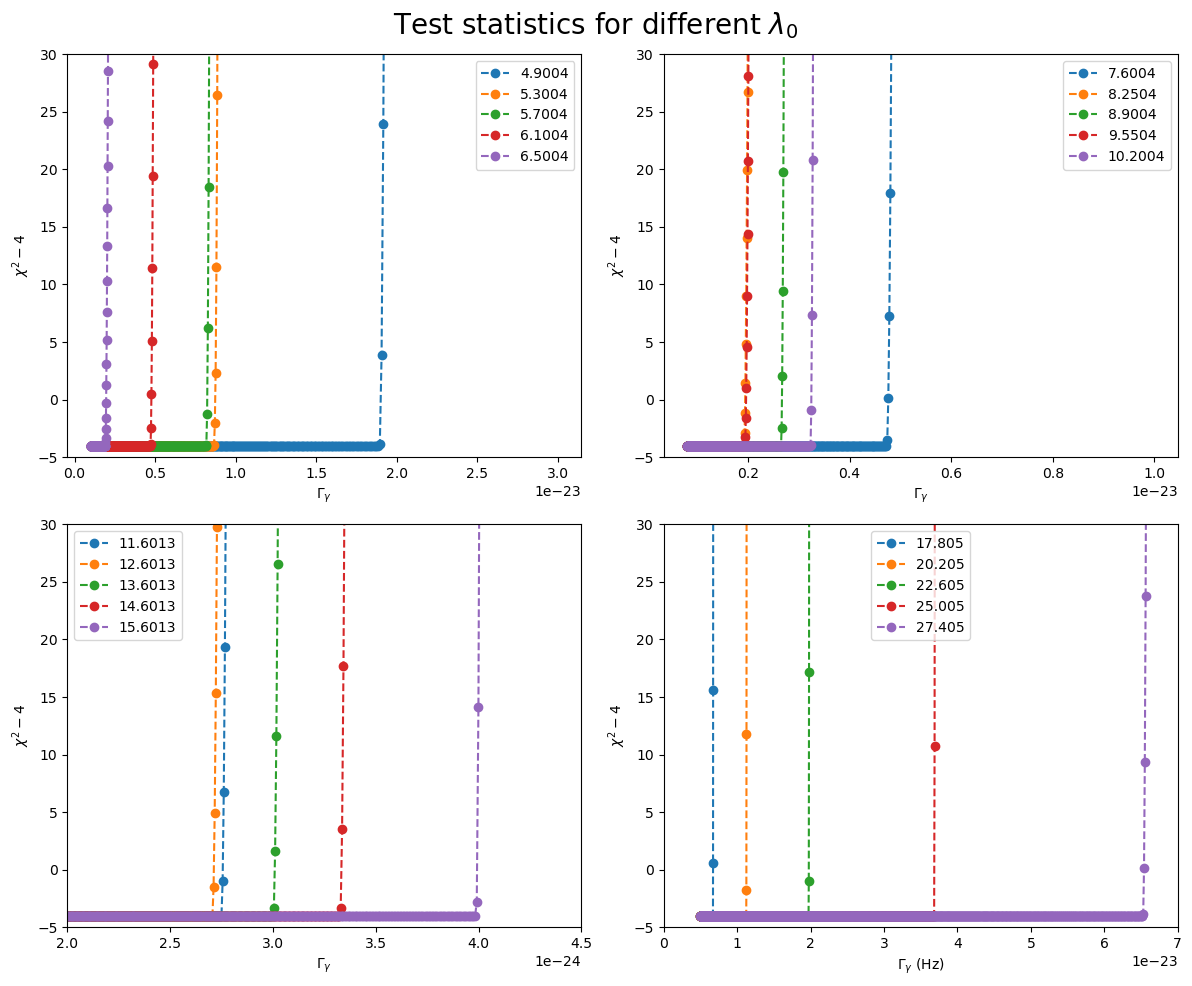

In [63]:
fig = plt.figure(figsize=(12,10))
fig.suptitle('Test statistics for different $\\lambda_0$', fontsize=20)

step = 500
ax1 = plt.subplot(221)
for i in range(5):
    ax1.plot(gammaTest1,chi2M4_1[:,i*step],'--o')
ax1.legend(np.round(wvl_ch1_ct[:4*step+1][::step],4))
ax1.set_ylim(-5,30)
ax1.set_xlabel('$\\Gamma_\\gamma$')
ax1.set_ylabel('$\\chi^2 - 4$')

step = 500
ax2 = plt.subplot(222)
for i in range(5):
    ax2.plot(gammaTest2,chi2M4_2[:,i*step],'--o')
ax2.legend(np.round(wvl_ch2_ct[:4*step+1][::step],4))
#plt.xlim(3e-23,5e-23)
ax2.set_ylim(-5,30)
ax2.set_xlabel('$\\Gamma_\\gamma$')
ax2.set_ylabel('$\\chi^2 - 4$')

step = 400
ax3 = plt.subplot(223)
for i in range(5):
    ax3.plot(gammaTest3,chi2M4_3[:,i*step],'--o')
ax3.legend(np.round(wvl_ch3_ct[:4*step+1][::step],4))
ax3.set_xlim(0.2e-23,0.45e-23)
ax3.set_ylim(-5,30)
ax3.set_xlabel('$\\Gamma_\\gamma$')
ax3.set_ylabel('$\\chi^2 - 4$')

step = 400
ax4 = plt.subplot(224)
for i in range(5):
    ax4.plot(gammaTest4,chi2M4_4[:,i*step],'--o')
ax4.legend(np.round(wvl_ch4_ct[:4*step+1][::step],4))
plt.xlim(0,0.7e-22)
ax4.set_ylim(-5,30)
ax4.set_xlabel('$\\Gamma_\\gamma$ (Hz)')
ax4.set_ylabel('$\\chi^2 - 4$')
plt.tight_layout(pad=1)
plt.savefig('conserv_Chi2_agst_gamma.pdf')

In [53]:
#Flux-to-error ratio
print(np.mean(fluxCut_c/errorCut_c))
print(np.mean(flux_ch1_ct/bkgdErr_ch1_ct))
print(np.mean(flux_ch2_ct/bkgdErr_ch2_ct))
print(np.mean(flux_ch3_ct/bkgdErr_ch3_ct))
print(np.mean(flux_ch4_ct/bkgdErr_ch4_ct))

170.33395659735262
210.42485847059137
236.1048572547854
1079.734468319081
1580.7978304081364


Q: Why is the chi2 value increases so rapidly with gamma (compared with what we see for the old set of data)? 
A: It is probably due to the higher flux-to-error ratio compared to the previous set of data (current 170, previous 110). The above list of numbers agree perfectly with the observed trend.

In [54]:
#Extract bounds
gammaBd_ch1 = extractBound(wvl_ch1_ct,gammaTest1,chi2M4_1,0)
gammaBd_ch2 = extractBound(wvl_ch2_ct,gammaTest2,chi2M4_2,0)
gammaBd_ch3 = extractBound(wvl_ch3_ct,gammaTest3,chi2M4_3,0)
gammaBd_ch4 = extractBound(wvl_ch4_ct,gammaTest4,chi2M4_4,0)
couplingBd_ch1 = gammaToCoupling(gammaBd_ch1,massArr_ch1)
couplingBd_ch2 = gammaToCoupling(gammaBd_ch2,massArr_ch2)
couplingBd_ch3 = gammaToCoupling(gammaBd_ch3,massArr_ch3)
couplingBd_ch4 = gammaToCoupling(gammaBd_ch4,massArr_ch4)

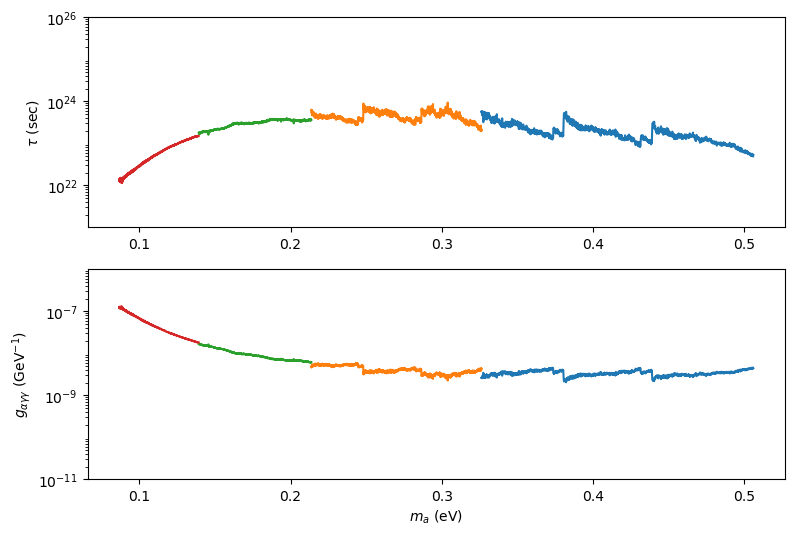

In [61]:
#Constraint plots
plt.figure(figsize=(9,6))
plt.subplot(211) 
plt.plot(massArr_ch1,1/gammaBd_ch1)
plt.plot(massArr_ch2,1/gammaBd_ch2)
plt.plot(massArr_ch3,1/gammaBd_ch3)
plt.plot(massArr_ch4,1/gammaBd_ch4)
plt.yscale('log')
plt.ylabel('$\\tau$ (sec)')
plt.ylim(1e21,1e26)
plt.yticks([1e22,1e24,1e26])

plt.subplot(212)
plt.plot(massArr_ch1,couplingBd_ch1)
plt.plot(massArr_ch2,couplingBd_ch2)
plt.plot(massArr_ch3,couplingBd_ch3)
plt.plot(massArr_ch4,couplingBd_ch4)
plt.yscale('log')
plt.xlabel('$m_a$ (eV)')
plt.ylabel('$g_{\\alpha\\gamma\\gamma}$ (GeV$^{-1}$)')
plt.ylim(1e-11,1e-6)
plt.yticks([1e-11,1e-9,1e-7])
plt.savefig('conservConstraint.pdf')
plt.show()

### Continuum constriants

In [90]:
lmd0_test = wvlCut_c[locate(wvlCut_c,5.443)-3]
fc = continuumFitting(wvlCut_c,fluxCut_c,errorCut_c,d_lmd_ch1)
gammaCut = np.append(0,np.logspace(-25,np.log10(5e-24),100))
chi2Cut, betaCut, errorCut_new, errorFac_cut, mask_cut= fc.minChi2_continuum(lmd0_test,gammaCut,wvlCut_c,fluxCut_c,errorCut_c)

No. of test masses:  73


(1.2, 1.6)

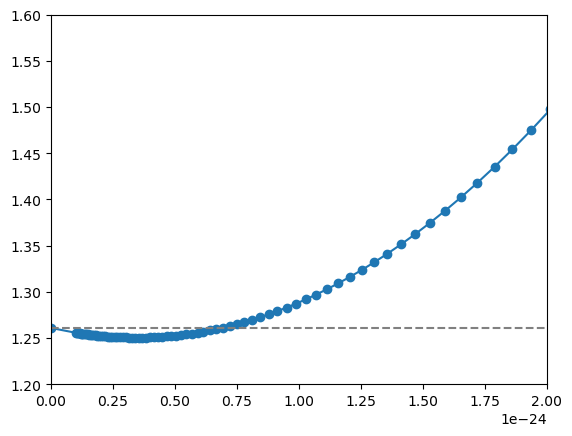

In [100]:
plt.plot(gammaCut,chi2Cut/len(wvlCut_c),'-o')
plt.axhline(y = chi2Cut[0]/len(wvlCut_c), color = 'grey', linestyle = '--') 
plt.xlim(0,2e-24)
plt.ylim(1.2,1.6)

[3.40408745e-25 2.74077453e+01 2.84110591e+01 2.81979631e+01
 2.73683309e+01 2.14132003e+01]
likelihood =  273.81669326551287 g =  6.93570090613198e-10
[8.11987976e-25 2.72343673e+01 2.84293293e+01 2.78756275e+01
 2.73399403e+01 2.12941152e+01]
likelihood =  278.0488695335374 g =  1.0711857863754045e-09


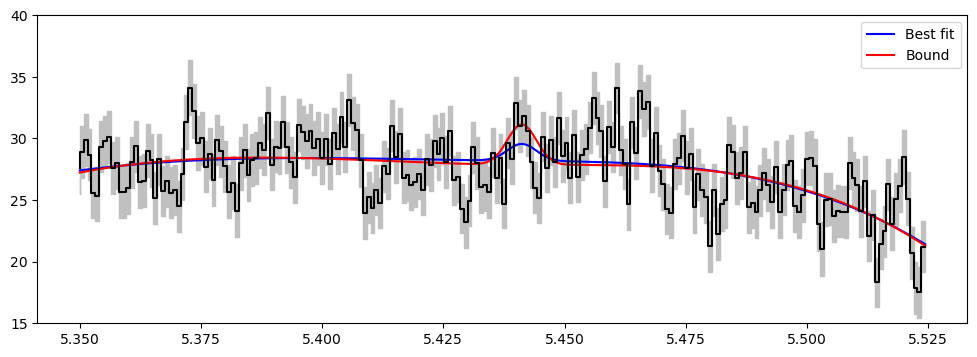

In [92]:
theta_min = np.append(gammaCut[np.argmin(chi2Cut)],betaCut[np.argmin(chi2Cut),:])
best_fit_model = theoFlux(wvlCut_c,lmd0_test,d_lmd_ch1,theta_min[0]) + fc.continuum(theta_min[1:],wvlCut_c)
print(theta_min)
print('likelihood = ', np.min(chi2Cut), 'g = ', gammaToCoupling(theta_min[0],ma_test))

gammaBd = np.interp(4,chi2Cut[np.argmin(chi2Cut):] - np.min(chi2Cut),gammaCut[np.argmin(chi2Cut):])
i_bd = locate(gammaCut,gammaBd)
theta_bd  = np.append(gammaCut[i_bd],betaCut[i_bd,:])
bound_model = theoFlux(wvlCut_c,lmd0_test,d_lmd_ch1,theta_bd[0]) + fc.continuum(theta_bd[1:],wvlCut_c)
print(theta_bd)
print('likelihood = ', chi2Cut[i_bd], 'g = ', gammaToCoupling(theta_bd[0],ma_test))

plt.figure(figsize=(12, 4))
plt.plot(wvlCut_c,best_fit_model, color='blue')
plt.plot(wvlCut_c,bound_model, color='red')
plt.step(wvlCut_c,fluxCut_c,'black')
plt.fill_between(wvlCut_c,fluxCut_c+errorCut_new,fluxCut_c-errorCut_new,step="pre",color='silver')
plt.ylim(15,40)
plt.legend(('Best fit', 'Bound'))
plt.show()

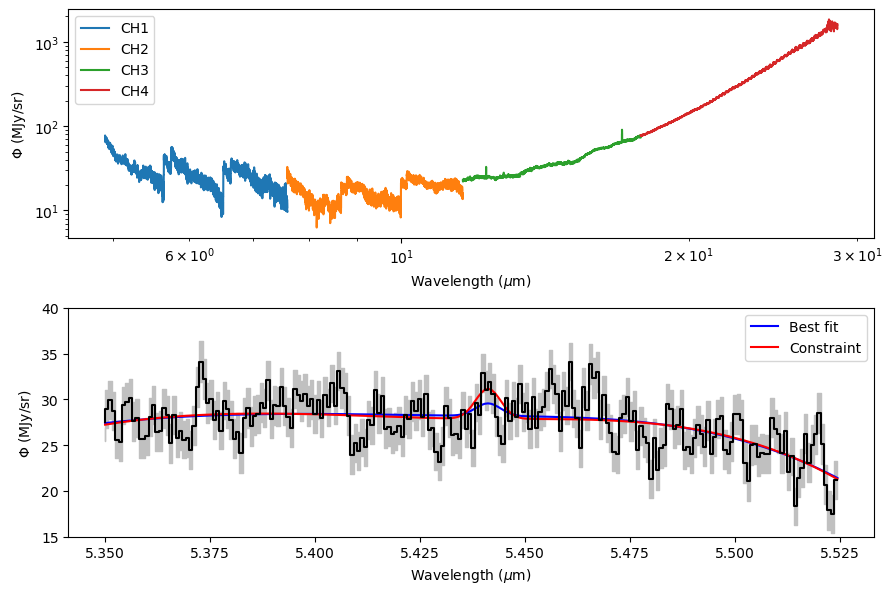

In [102]:
plt.figure(figsize=(9,6))
plt.subplot(211)  
plt.step(wvl_ch1_ct,flux_ch1_ct)
plt.step(wvl_ch2_ct,flux_ch2_ct)
plt.step(wvl_ch3_ct,flux_ch3_ct)
plt.step(wvl_ch4_ct,flux_ch4_ct)
plt.xscale('log')
plt.yscale('log')
plt.legend(('CH1','CH2','CH3','CH4'))
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (MJy/sr)")

plt.subplot(212)
plt.plot(wvlCut_c,best_fit_model, color='blue')
plt.plot(wvlCut_c,bound_model, color='red')
plt.step(wvlCut_c,fluxCut_c,'black')
plt.fill_between(wvlCut_c,fluxCut_c+errorCut_new,fluxCut_c-errorCut_new,step="pre",color='silver')
plt.ylim(15,40)
plt.xlabel("Wavelength ($\\mu$m)")
plt.ylabel("$\\Phi$ (MJy/sr)")
plt.legend(('Best fit', 'Constraint'))
plt.tight_layout(pad=0.9)
#plt.savefig("TCha_spectrum2.pdf")
plt.show()

#### Full-range analysis

In [103]:
fc1 = continuumFitting(wvl_ch1_ct,flux_ch1_ct,bkgdErr_ch1_ct,d_lmd_ch1)
gammaTest1 = np.append(0,np.logespace(-26,-23,120))
chi2_ch1_contin, beta_ch1, errorNew_ch1, errorFac_ch1, mask_ch1 = fc1.constraints_continuum(gammaTest1)

No. of test masses:  1126


100%|████████████████████████████████████████████████████████████████████████| 1126/1126 [2:00:18<00:00,  6.41s/it]

Duration:  120.30175548394521  [min]


In [104]:
fc2 = continuumFitting(wvl_ch2_ct,flux_ch2_ct,bkgdErr_ch2_ct,d_lmd_ch2)
gammaTest2 = np.append(0,np.logspace(np.log10(5e-27),-24),120)
chi2_ch2_contin, beta_ch2, errorNew_ch2, errorFac_ch2, mask_ch2 = fc2.constraints_continuum(gammaTest2)

No. of test masses:  1026


100%|██████████████████████████████████████████████████████████████████████████| 1026/1026 [21:28<00:00,  1.26s/it]

Duration:  21.474180169900258  [min]


In [111]:
fc3 = continuumFitting(wvl_ch3_ct,flux_ch3_ct,bkgdErr_ch3_ct,d_lmd_ch3)
gammaTest3 = np.append(0,np.logspace(np.log10(5e-27),-24),120)
chi2_ch3_contin, beta_ch3, errorNew_ch3, errorFac_ch3, mask_ch3 = fc3.constraints_continuum(gammaTest3)

No. of test masses:  827


100%|████████████████████████████████████████████████████████████████████████████| 827/827 [41:29<00:00,  3.01s/it]

Duration:  41.49778391917547  [min]


In [112]:
fc4 = continuumFitting(wvl_ch4_ct,flux_ch4_ct,bkgdErr_ch4_ct,d_lmd_ch4)
gammaTest4 = np.append(0,np.logspace(-26,-23,120))
chi2_ch4_contin, beta_ch4, errorNew_ch4, errorFac_ch4, mask_ch4 = fc4.constraints_continuum(gammaTest4)

No. of test masses:  600


100%|██████████████████████████████████████████████████████████████████████████| 600/600 [1:24:45<00:00,  8.48s/it]

Duration:  84.76215399901072  [min]


In [115]:
#Storing result arrays:
# np.savez('chi2_contin.npz',chi2_ch1_contin,chi2_ch2_contin,chi2_ch3_contin,chi2_ch4_contin)
# np.savez('gammaTest_contin.npz',gammaTest1,gammaTest2,gammaTest3,gammaTest4)
# np.savez('beta.npz',beta_ch1,beta_ch2,beta_ch3,beta_ch4)
# np.savez('modified_error.npz',errorNew_ch1,errorNew_ch2,errorNew_ch3,errorNew_ch4)

In [116]:
#Loading result arrays:
# chi2_ch1_contin,chi2_ch2_contin,chi2_ch3_contin,chi2_ch4_contin = np.load('chi2_contin.npz')
# gammaTest1,gammaTest2,gammaTest3,gammaTest4 = np.load('gammaTest_contin.npz')
# beta_ch1,beta_ch2,beta_ch3,beta_ch4 = np.load('beta.npz')
# errorNew_ch1,errorNew_ch2,errorNew_ch3,errorNew_ch4 = np.load('modified_error.npz')

In [117]:
#Extract bound
massArr_ch1_bd = wvlToMass(fc1.wvl_bd)
massArr_ch2_bd = wvlToMass(fc2.wvl_bd)
massArr_ch3_bd = wvlToMass(fc3.wvl_bd)
massArr_ch4_bd = wvlToMass(fc4.wvl_bd)
gammaBound1_contin = fc1.extractBound_continuum(chi2_ch1_contin,gammaTest1,4)
gammaBound2_contin = fc2.extractBound_continuum(chi2_ch2_contin,gammaTest2,4)
gammaBound3_contin = fc3.extractBound_continuum(chi2_ch3_contin,gammaTest3,4)
gammaBound4_contin = fc4.extractBound_continuum(chi2_ch4_contin,gammaTest4,4)
couplingBound1_contin = gammaToCoupling(gammaBound1_contin,massArr_ch1_bd)
couplingBound2_contin = gammaToCoupling(gammaBound2_contin,massArr_ch2_bd)
couplingBound3_contin = gammaToCoupling(gammaBound3_contin,massArr_ch3_bd)
couplingBound4_contin = gammaToCoupling(gammaBound4_contin,massArr_ch4_bd)

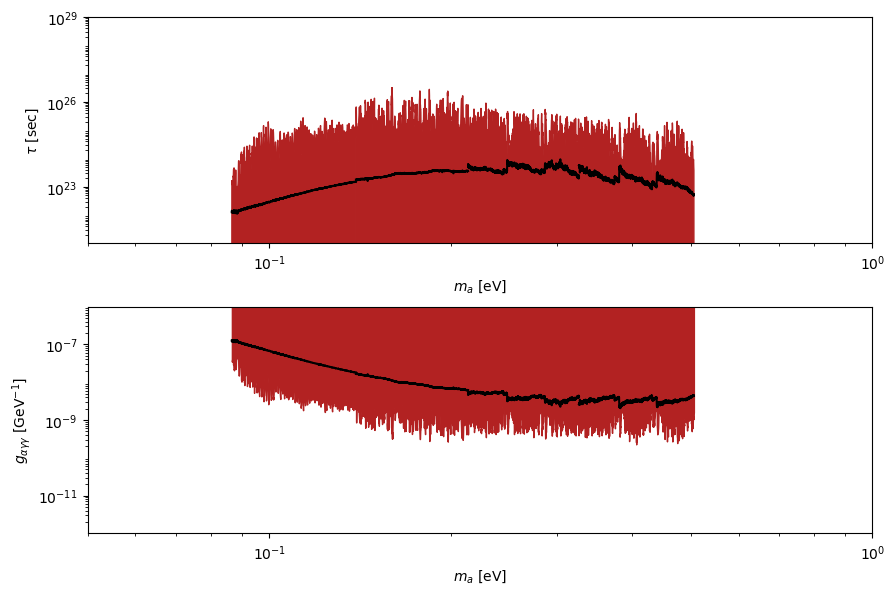

In [119]:
#Plot
plt.figure(figsize=(9, 6))
plt.subplot(211)
plt.fill_between(massArr_ch1_bd,1/gammaBound1_contin,0,color='firebrick')
plt.fill_between(massArr_ch2_bd,1/gammaBound2_contin,0,color='firebrick')
plt.fill_between(massArr_ch3_bd,1/gammaBound3_contin,0,color='firebrick')
plt.fill_between(massArr_ch4_bd,1/gammaBound4_contin,0,color='firebrick')
plt.plot(massArr_ch1,1/gammaBd_ch1,color='black')
plt.plot(massArr_ch2,1/gammaBd_ch2,color='black')
plt.plot(massArr_ch3,1/gammaBd_ch3,color='black')
plt.plot(massArr_ch4,1/gammaBd_ch4,color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e-2,1)
#plt.xticks((0.1,0.5,0.7,1))
plt.ylim(1e21,1e29)
plt.yticks((1e23,1e26,1e29))
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$\\tau$ [sec]')

plt.subplot(212)
plt.fill_between(massArr_ch1_bd,couplingBound1_contin,1e-6,color='firebrick')
plt.fill_between(massArr_ch2_bd,couplingBound2_contin,1e-6,color='firebrick')
plt.fill_between(massArr_ch3_bd,couplingBound3_contin,1e-6,color='firebrick')
plt.fill_between(massArr_ch4_bd,couplingBound4_contin,1e-6,color='firebrick')
plt.plot(massArr_ch1,couplingBd_ch1,color='black')
plt.plot(massArr_ch2,couplingBd_ch2,color='black')
plt.plot(massArr_ch3,couplingBd_ch3,color='black')
plt.plot(massArr_ch4,couplingBd_ch4,color='black')
plt.xscale('log')
plt.yscale('log')
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e-2,1)
#plt.xticks((1,3,6))
plt.ylim((1e-12,1e-6))
plt.yticks([1e-11,1e-9,1e-7])
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$g_{\\alpha\\gamma\\gamma}$ [GeV$^{-1}$]')
plt.tight_layout(pad=0.9)
plt.savefig('contin_constraint.pdf')

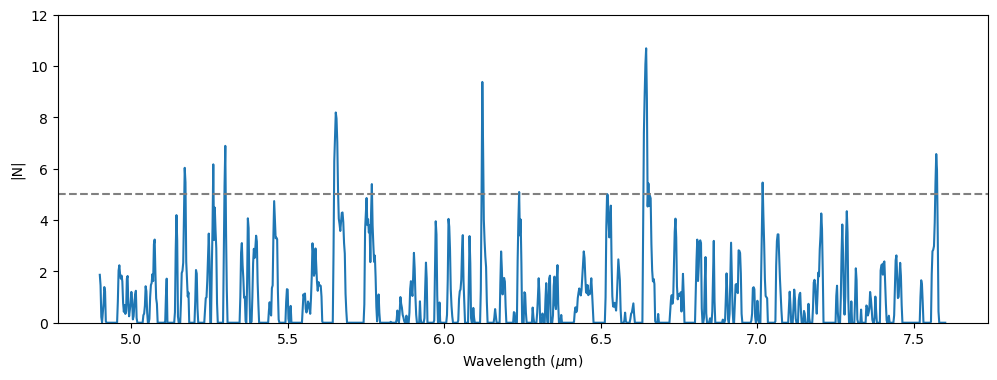

Significant detection:
N = 6.03 at (λ_0,i) = ('5.17', 113)
N = 5.47 at (λ_0,i) = ('5.17', 114)
N = 6.17 at (λ_0,i) = ('5.26', 151)
N = 5.36 at (λ_0,i) = ('5.30', 166)
N = 6.89 at (λ_0,i) = ('5.30', 167)
N = 6.29 at (λ_0,i) = ('5.65', 312)
N = 7.19 at (λ_0,i) = ('5.65', 313)
N = 8.19 at (λ_0,i) = ('5.65', 314)
N = 7.95 at (λ_0,i) = ('5.66', 315)
N = 7.03 at (λ_0,i) = ('5.66', 316)
N = 5.17 at (λ_0,i) = ('5.66', 317)
N = 5.40 at (λ_0,i) = ('5.77', 362)
N = 5.01 at (λ_0,i) = ('6.12', 508)
N = 9.38 at (λ_0,i) = ('6.12', 509)
N = 6.89 at (λ_0,i) = ('6.12', 510)
N = 5.09 at (λ_0,i) = ('6.24', 558)
N = 5.01 at (λ_0,i) = ('6.52', 675)
N = 7.41 at (λ_0,i) = ('6.64', 724)
N = 8.86 at (λ_0,i) = ('6.64', 725)
N = 10.07 at (λ_0,i) = ('6.64', 726)
N = 10.69 at (λ_0,i) = ('6.65', 727)
N = 8.72 at (λ_0,i) = ('6.65', 728)
N = 5.43 at (λ_0,i) = ('6.65', 730)
N = 5.46 at (λ_0,i) = ('7.02', 882)
N = 5.45 at (λ_0,i) = ('7.57', 1112)
N = 6.57 at (λ_0,i) = ('7.57', 1113)
N = 5.95 at (λ_0,i) = ('7.57', 1114)


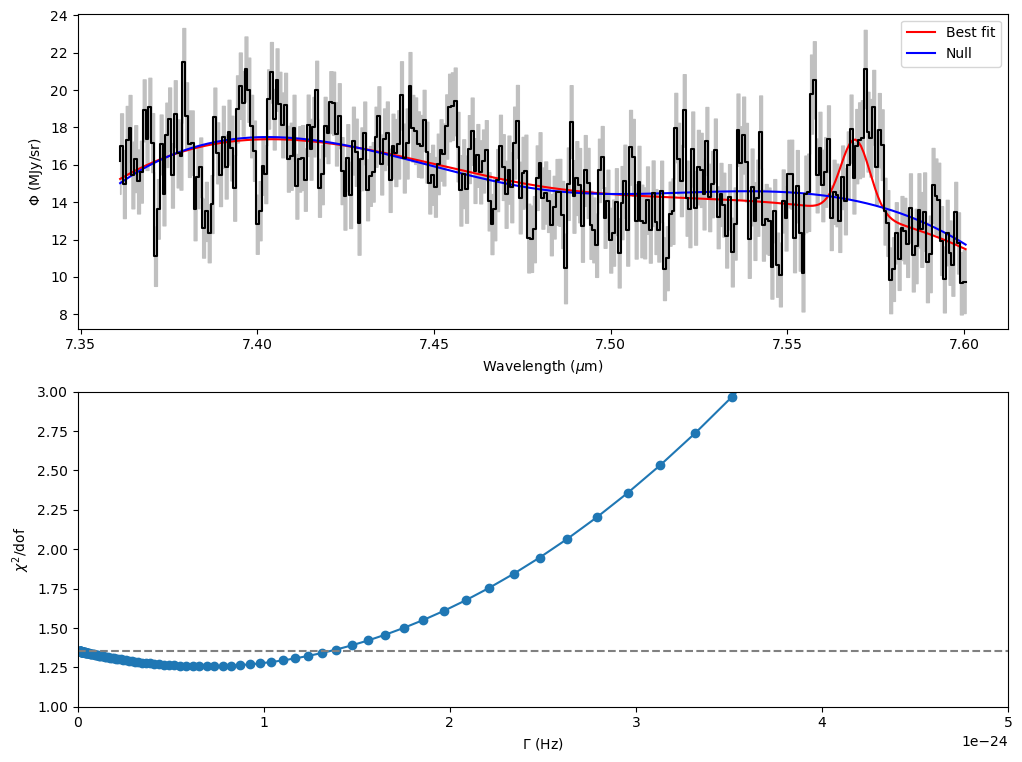

Parameters: [6.92366640e-25 1.52447106e+01 1.71352887e+01 1.48296054e+01
 1.40489436e+01 1.14824172e+01]
chi2 = 376.9500954426792 N = 5.44722581340245


In [122]:
fc1.fitting_result(gammaTest1,plot_i=1112,plotFit=True,chi2_LIM=(1,3))

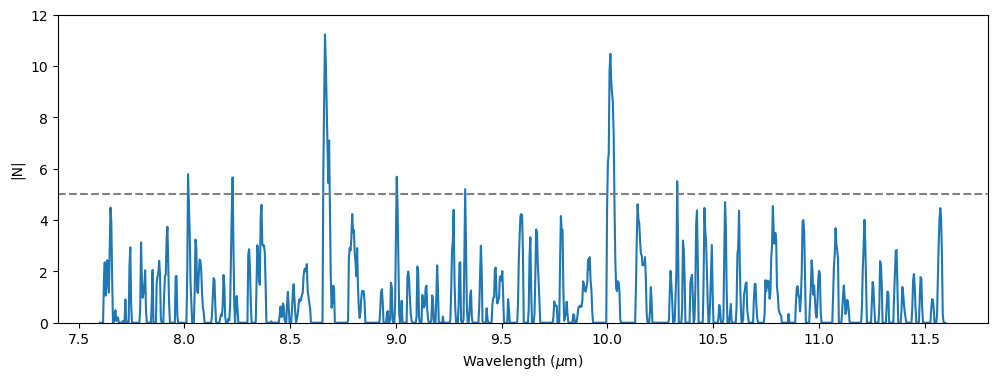

Significant detection:
N = 5.79 at (λ_0,i) = ('8.02', 107)
N = 5.66 at (λ_0,i) = ('8.23', 161)
N = 5.92 at (λ_0,i) = ('8.66', 271)
N = 8.74 at (λ_0,i) = ('8.66', 272)
N = 11.23 at (λ_0,i) = ('8.67', 273)
N = 10.14 at (λ_0,i) = ('8.67', 274)
N = 8.62 at (λ_0,i) = ('8.67', 275)
N = 7.21 at (λ_0,i) = ('8.68', 276)
N = 5.44 at (λ_0,i) = ('8.68', 277)
N = 7.10 at (λ_0,i) = ('8.68', 278)
N = 5.69 at (λ_0,i) = ('9.00', 360)
N = 5.21 at (λ_0,i) = ('9.33', 443)
N = 6.25 at (λ_0,i) = ('10.00', 616)
N = 6.58 at (λ_0,i) = ('10.01', 617)
N = 9.82 at (λ_0,i) = ('10.01', 618)
N = 10.48 at (λ_0,i) = ('10.01', 619)
N = 9.44 at (λ_0,i) = ('10.02', 620)
N = 8.94 at (λ_0,i) = ('10.02', 621)
N = 8.61 at (λ_0,i) = ('10.03', 622)
N = 7.31 at (λ_0,i) = ('10.03', 623)
N = 5.51 at (λ_0,i) = ('10.33', 700)
Strongest detection:
N = 11.23 at (λ_0,i) = ('8.67', 273)


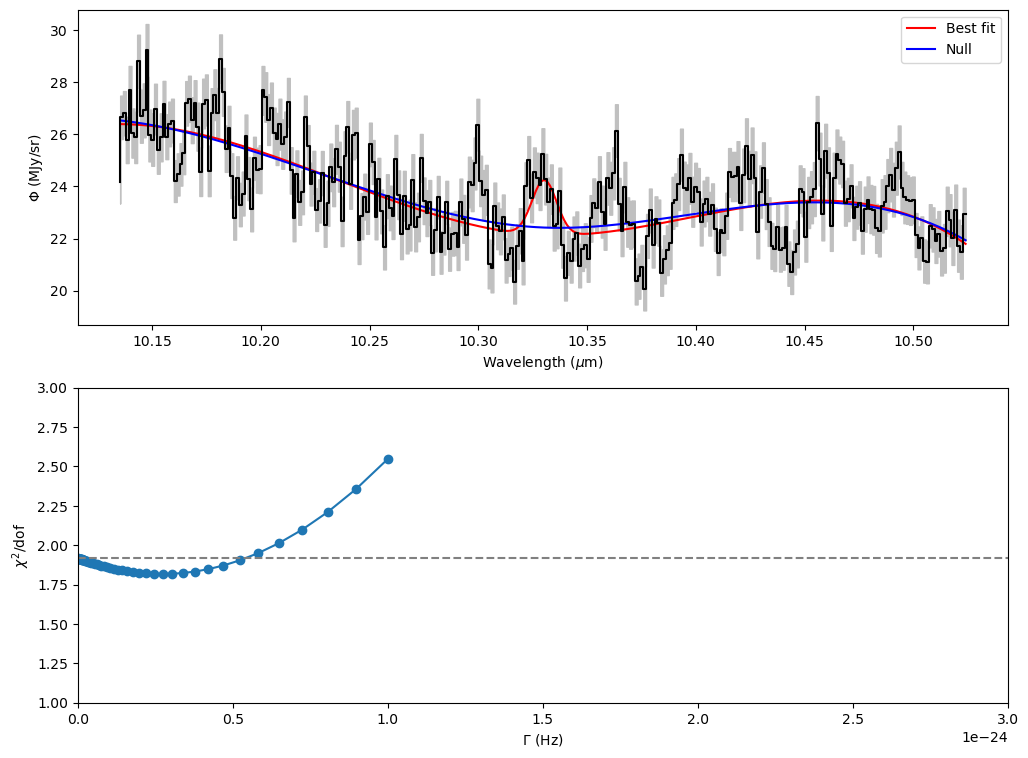

Parameters: [2.73201104e-25 2.63926784e+01 2.43369749e+01 2.21364154e+01
 2.32491432e+01 2.17953677e+01]
chi2 = 545.1970213852112 N = 5.511533220535689


In [124]:
fc2.fitting_result(gammaTest2,plot_i=700,plotFit=True,chi2_LIM=(1,3),gamma_LIM=(0,3e-24))

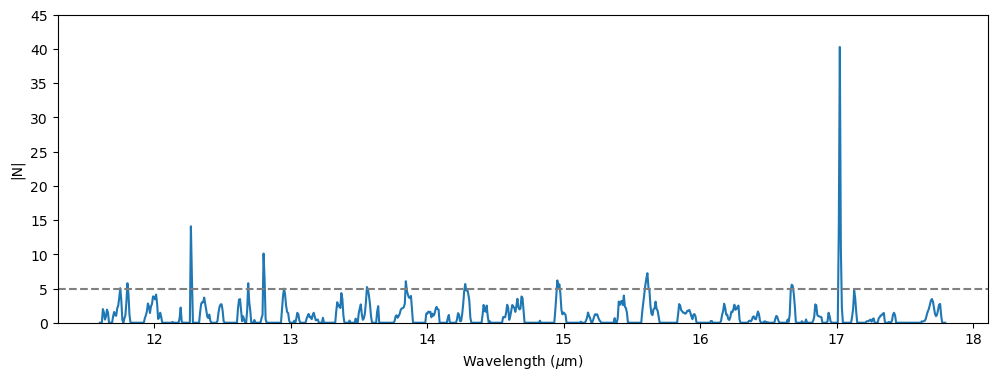

Significant detection:
N = 5.04 at (λ_0,i) = ('11.75', 20)
N = 5.76 at (λ_0,i) = ('11.80', 27)
N = 14.09 at (λ_0,i) = ('12.27', 89)
N = 6.60 at (λ_0,i) = ('12.28', 90)
N = 5.77 at (λ_0,i) = ('12.69', 145)
N = 10.10 at (λ_0,i) = ('12.80', 160)
N = 6.33 at (λ_0,i) = ('12.81', 161)
N = 5.22 at (λ_0,i) = ('13.56', 261)
N = 6.06 at (λ_0,i) = ('13.84', 299)
N = 5.65 at (λ_0,i) = ('14.28', 357)
N = 6.18 at (λ_0,i) = ('14.95', 447)
N = 5.20 at (λ_0,i) = ('14.96', 448)
N = 5.62 at (λ_0,i) = ('14.97', 449)
N = 5.50 at (λ_0,i) = ('15.60', 533)
N = 6.48 at (λ_0,i) = ('15.61', 534)
N = 7.23 at (λ_0,i) = ('15.61', 535)
N = 5.18 at (λ_0,i) = ('15.62', 536)
N = 5.55 at (λ_0,i) = ('16.67', 676)
N = 5.37 at (λ_0,i) = ('16.68', 677)
N = 13.96 at (λ_0,i) = ('17.02', 722)
N = 40.29 at (λ_0,i) = ('17.02', 723)
N = 10.88 at (λ_0,i) = ('17.03', 724)
Strongest detection:
N = 40.29 at (λ_0,i) = ('17.02', 723)


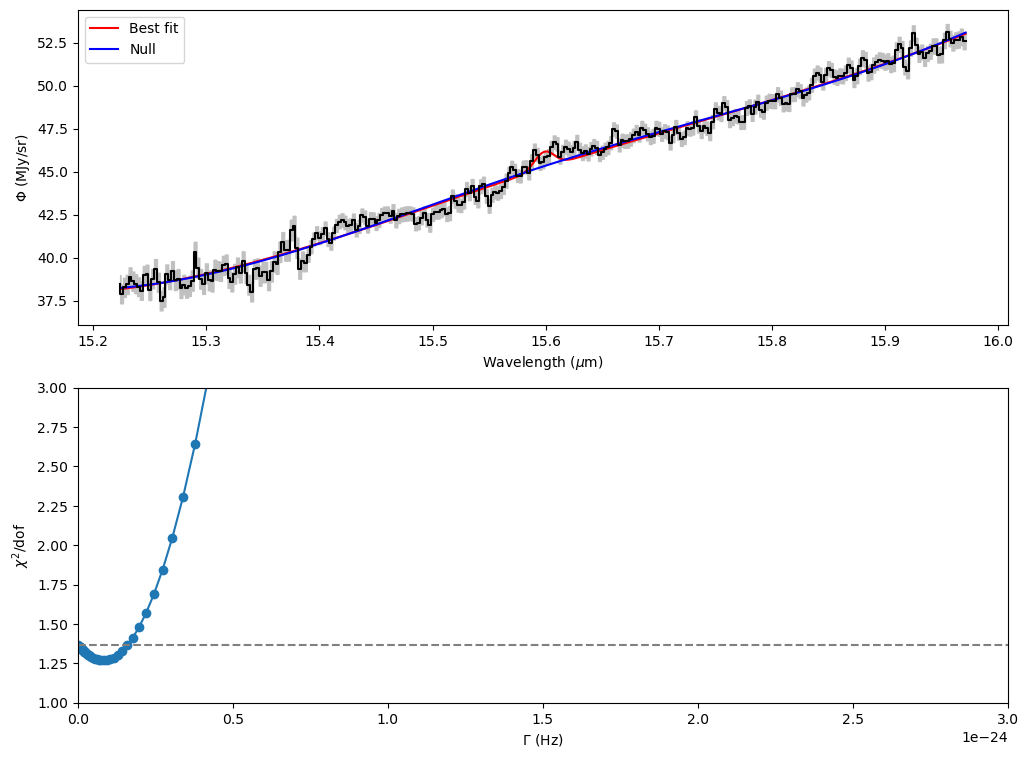

Parameters: [8.31619561e-26 3.81636587e+01 4.10556829e+01 4.51746013e+01
 4.88523083e+01 5.30166611e+01]
chi2 = 380.52875060721556 N = 5.500109828219256


In [133]:
fc3.fitting_result(gammaTest3,plot_i=533,plotFit=True,yLIM=(0,45),chi2_LIM=(1,3),gamma_LIM=(0,3e-24))

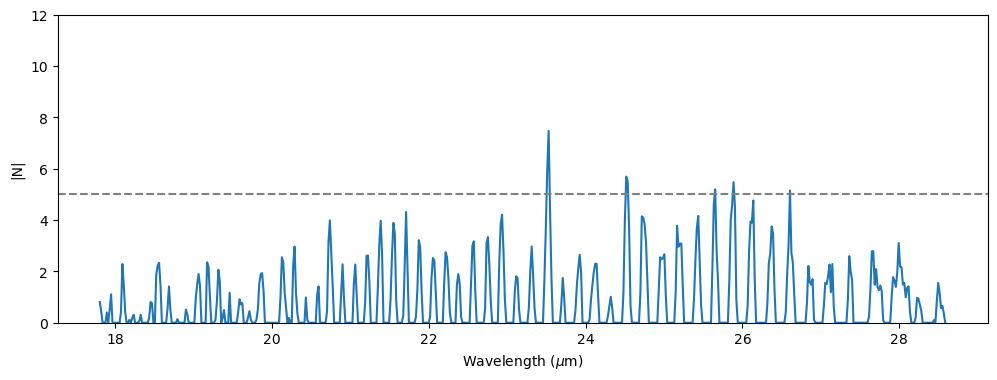

Significant detection:
N = 5.95 at (λ_0,i) = ('23.51', 317)
N = 7.47 at (λ_0,i) = ('23.53', 318)
N = 5.69 at (λ_0,i) = ('24.52', 373)
N = 5.51 at (λ_0,i) = ('24.54', 374)
N = 5.20 at (λ_0,i) = ('25.65', 436)
N = 5.48 at (λ_0,i) = ('25.89', 449)
N = 5.15 at (λ_0,i) = ('26.61', 489)
Strongest detection:
N = 7.47 at (λ_0,i) = ('23.53', 318)


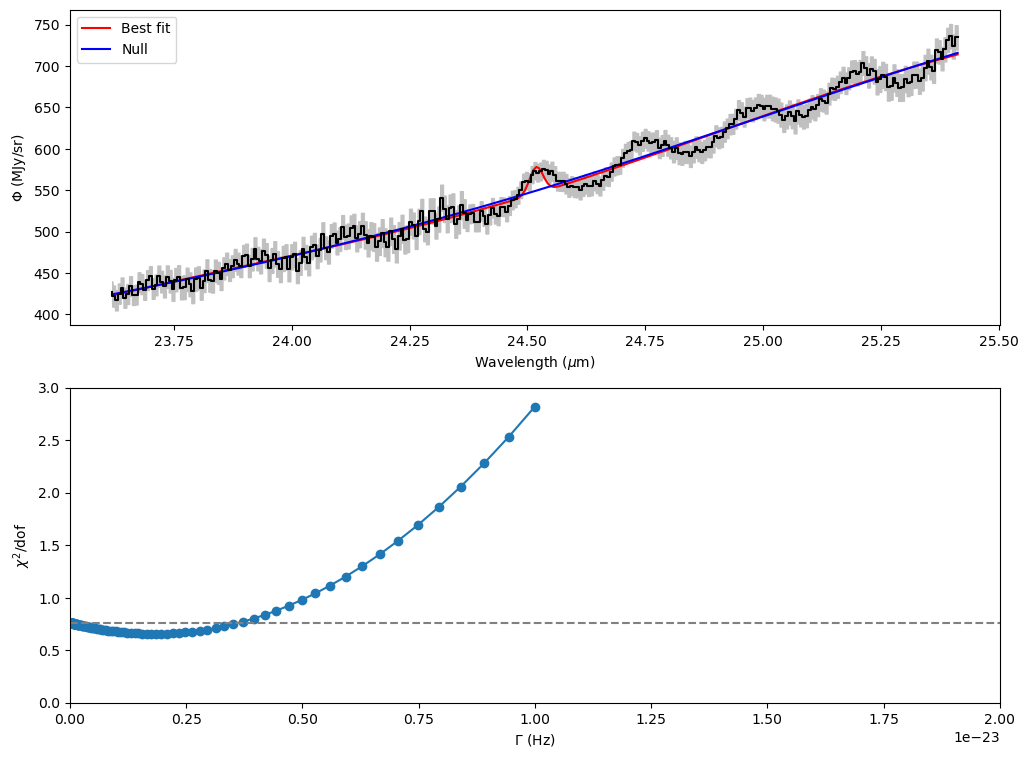

Parameters: [1.85740907e-24 4.22766557e+02 4.79429741e+02 5.45615757e+02
 6.32460647e+02 7.14041114e+02]
chi2 = 196.59561930279546 N = 5.689398593377669


In [142]:
fc4.fitting_result(gammaTest4,plot_i=373,plotFit=True,chi2_LIM=(0,3),gamma_LIM=(0,2e-23))

Text(0, 0.5, '$|N|$')

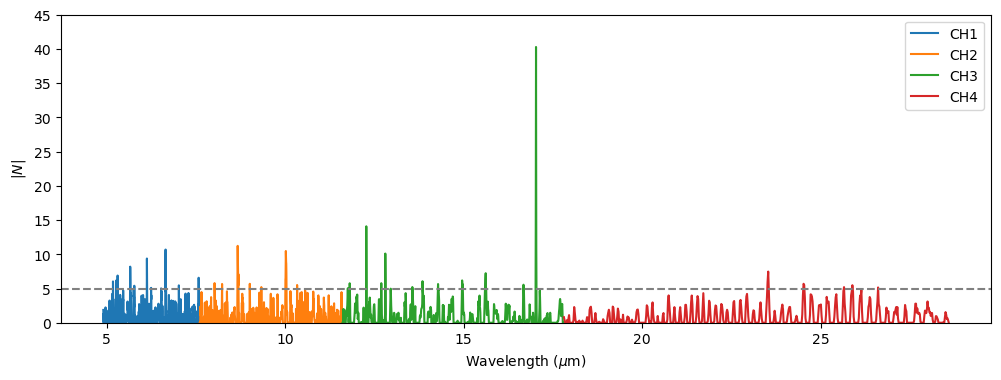

In [139]:
#Detection significance
n2_ch1 = fc1.detection_signif(chi2_ch1_contin,gammaTest1)
n2_ch2 = fc1.detection_signif(chi2_ch2_contin,gammaTest2)
n2_ch3 = fc1.detection_signif(chi2_ch3_contin,gammaTest3)
n2_ch4 = fc1.detection_signif(chi2_ch4_contin,gammaTest4)
plt.figure(figsize=(12,4))
plt.plot(fc1.wvl_bd,np.sqrt(-n2_ch1))
plt.plot(fc2.wvl_bd,np.sqrt(-n2_ch2))
plt.plot(fc3.wvl_bd,np.sqrt(-n2_ch3))
plt.plot(fc4.wvl_bd,np.sqrt(-n2_ch4))
plt.axhline(y = 5, color = 'grey', linestyle = '--') 
plt.ylim((0,45))
plt.legend(('CH1','CH2','CH3','CH4'))
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('$|N|$')

now the fluatuation is too large to provide stronger bounds. 1) require a more accurate model of the background or 2) reduce the fluctuation of the spectrum.